In [16]:
# 🛰️ Import libraries
import ee
import geemap

# 🌐 Authenticate & initialize Earth Engine with your GEE project ID
ee.Authenticate()
ee.Initialize(project='urban-expansion-study-2025')  # ⬅️ Replace with your actual GEE project ID

# 📍 Define Abuja boundary using FAO GAUL
abuja = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Abuja')) \
    .geometry()

# 🛰️ Load Sentinel-5P NO2 dataset (2019–mid-2025)
no2_dataset = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2") \
    .select('NO2_column_number_density') \
    .filterDate('2019-01-01', '2025-06-12') \
    .filterBounds(abuja)

# 📊 Compute multi-year median and clip to Abuja
no2_median = no2_dataset.median().clip(abuja)

# 🎨 Visualization parameters
vis_params = {
    'min': 0,
    'max': 0.0002,
    'palette': ['black', 'purple', 'blue', 'green', 'yellow', 'red']
}

# 🗺️ Create map and add layers
Map = geemap.Map(center=[9.05785, 7.49508], zoom=9)  # Abuja coordinates
Map.addLayer(no2_median, vis_params, "NO₂ - 2019 to mid-2025")
Map.addLayer(abuja, {}, "Abuja Boundary")
Map


Map(center=[9.05785, 7.49508], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [4]:
# Get all ADM1 names in Nigeria to find correct Abuja entry
nigeria_adm1 = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM0_NAME', 'Nigeria'))

names = nigeria_adm1.aggregate_array('ADM1_NAME')
print(names.getInfo())


['Abia', 'Bauchi', 'Bayelsa', 'Ebonyi', 'Ekiti', 'Enugu', 'Gombe', 'Nassarawa', 'Ondo', 'Plateau', 'Rivers', 'Sokoto', 'Zamfara', 'Abuja', 'Adamawa', 'Akwa Ibom', 'Anambra', 'Benue', 'Borno', 'Cross River', 'Delta', 'Edo', 'Imo', 'Jigawa', 'Kaduna', 'Kano', 'Katsina', 'Kebbi', 'Kogi', 'Kwara', 'Lagos', 'Niger', 'Ogun', 'Osun', 'Oyo', 'Taraba', 'Yobe']


🟢 Animated NO₂ GIF for Abuja: https://earthengine.googleapis.com/v1/projects/urban-expansion-study-2025/videoThumbnails/b57ac5ee7ea38c82306d8695e044f884-a802cb57c96ccc0f82e3cabcfa577c2c:getPixels


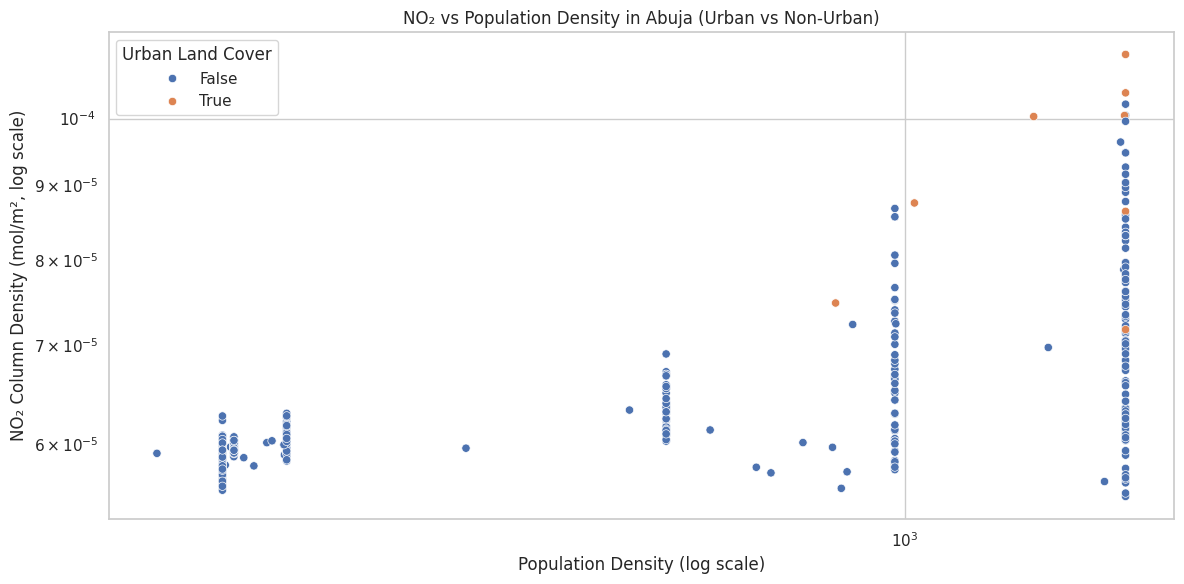

In [17]:
import ee
import geemap
import seaborn as sns
import matplotlib.pyplot as plt

# 🌍 Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='urban-expansion-study-2025')

# 📍 Get Abuja boundary
abuja = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Abuja')) \
    .geometry()

# 🛰️ Load Sentinel-5P NO₂ dataset (Jan 2019 – June 12, 2025)
no2_collection = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2") \
    .select('NO2_column_number_density') \
    .filterBounds(abuja) \
    .filterDate('2019-01-01', '2025-06-12')

# ⏳ Generate monthly median images
def get_monthly_image(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    img = no2_collection.filterDate(start, end).median().clip(abuja)
    return img.set({'system:time_start': start.millis()})

# ✅ Include Jan 2019 – June 2025
dates = [(y, m) for y in range(2019, 2025) for m in range(1, 13)] + [(2025, m) for m in range(1, 7)]
monthly_images = [get_monthly_image(y, m) for y, m in dates]
no2_monthly = ee.ImageCollection(monthly_images)

# 🎨 Visualization settings
vis = {
    'min': 0,
    'max': 0.0002,
    'palette': ['black', 'purple', 'blue', 'green', 'yellow', 'red']
}

# 🎞️ Generate animated NO₂ GIF
gif_config = {
    'region': abuja,
    'dimensions': 600,
    'framesPerSecond': 3,
    'format': 'gif',
    'palette': vis['palette'],
    'min': vis['min'],
    'max': vis['max']
}

gif_url = no2_monthly.getVideoThumbURL(gif_config)
print("🟢 Animated NO₂ GIF for Abuja:", gif_url)

# --- 🔍 CORRELATION ANALYSIS ---

# 🧍‍♂️ Load 2020 population density
pop = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density") \
    .filter(ee.Filter.eq('system:index', 'gpw_v4_population_density_rev11_2020_30_sec')) \
    .first() \
    .clip(abuja)

# 🏙️ Load MODIS land cover (Urban class: 13)
modis = ee.Image("MODIS/006/MCD12Q1/2020_01_01").select('LC_Type1').clip(abuja)

# 📊 Compute 5-year average NO₂
no2_mean = no2_collection.mean().clip(abuja)

# 📍 Sample 500 random points in Abuja
points = ee.FeatureCollection.randomPoints(region=abuja, points=500, seed=42)

# 🧪 Sample NO₂, population, and land cover
sampled = no2_mean.addBands(pop).addBands(modis).sampleRegions(
    collection=points,
    scale=1000,
    geometries=True
)

# ⬇️ Convert to pandas DataFrame
df = geemap.ee_to_df(sampled)

# 🧼 Rename columns
df = df.rename(columns={
    'NO2_column_number_density': 'NO2',
    'population_density': 'Population',
    'LC_Type1': 'LandCoverClass'
})
df['Urban'] = df['LandCoverClass'] == 13
df['Urban'] = df['Urban'].astype(bool)

# 📈 Plot: NO₂ vs Population (Urban vs Non-Urban)
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Population', y='NO2', hue='Urban')
plt.title('NO₂ vs Population Density in Abuja (Urban vs Non-Urban)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Population Density (log scale)')
plt.ylabel('NO₂ Column Density (mol/m², log scale)')
plt.legend(title="Urban Land Cover")
plt.tight_layout()
plt.savefig("NO2_vs_PopDensity_Abuja_2019_2025.png", dpi=300)
plt.show()


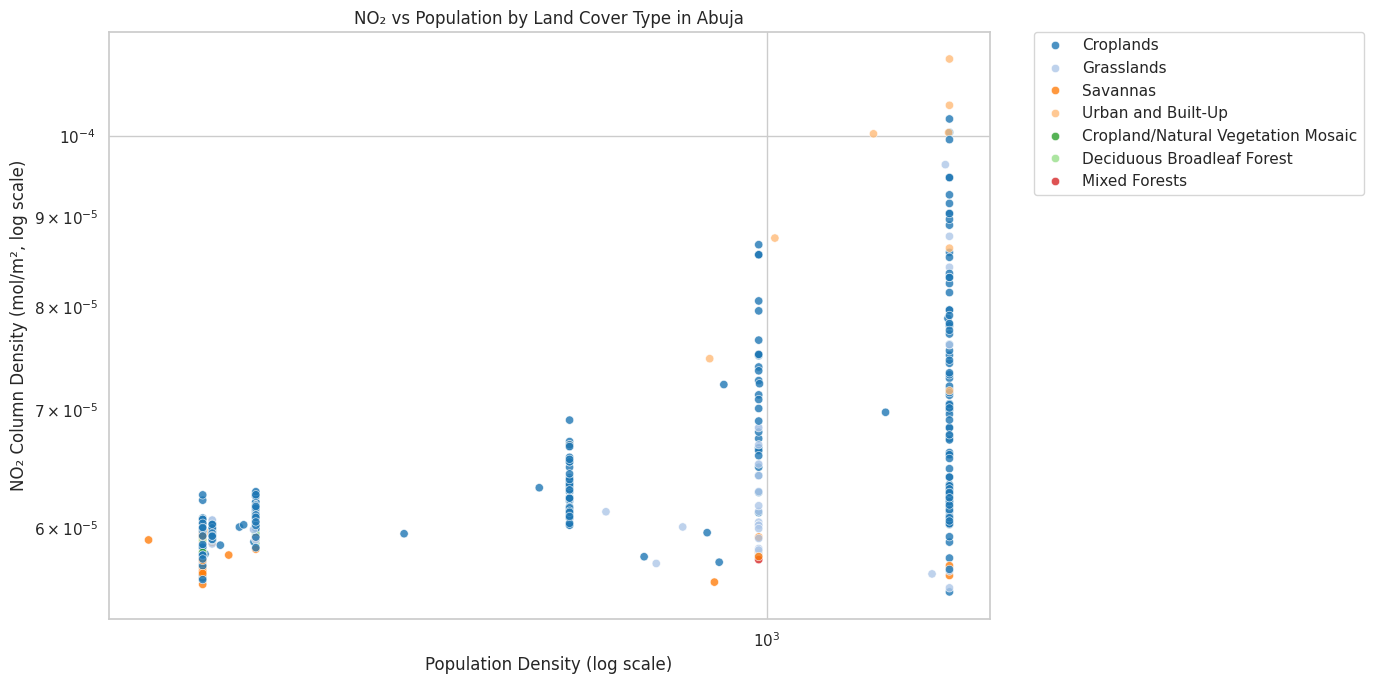

In [14]:
import ee
import geemap
import seaborn as sns
import matplotlib.pyplot as plt

# 🌐 Authenticate & initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='urban-expansion-study-2025')

# 📍 Define Abuja boundary
abuja = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM1_NAME', 'Abuja')) \
    .geometry()

# 🛰️ Load NO₂ dataset (2019–2025)
no2_collection = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2") \
    .select('NO2_column_number_density') \
    .filterBounds(abuja) \
    .filterDate('2019-01-01', '2025-06-12')

# ✅ Load MODIS Land Cover with full class labels
modis = ee.Image("MODIS/006/MCD12Q1/2020_01_01").select('LC_Type1').clip(abuja)

# 🧍‍♂️ Load 2020 population density
pop = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density") \
    .filter(ee.Filter.eq('system:index', 'gpw_v4_population_density_rev11_2020_30_sec')) \
    .first() \
    .clip(abuja)

# 📊 Compute 6-year mean NO₂
no2_mean = no2_collection.mean().clip(abuja)

# 📍 Generate random sample points over Abuja
points = ee.FeatureCollection.randomPoints(region=abuja, points=500, seed=42)

# 🧪 Sample NO₂, population, and land cover
sampled = no2_mean.addBands(pop).addBands(modis).sampleRegions(
    collection=points,
    scale=1000,
    geometries=True
)

# ⬇️ Convert to pandas
df = geemap.ee_to_df(sampled)

# 📖 Rename columns
df = df.rename(columns={
    'NO2_column_number_density': 'NO2',
    'LC_Type1': 'LandCover',
    'population_density': 'Population'
})

# 🌱 Map land cover codes to human-readable classes
modis_classes = {
    0: 'Water',
    1: 'Evergreen Needleleaf Forest',
    2: 'Evergreen Broadleaf Forest',
    3: 'Deciduous Needleleaf Forest',
    4: 'Deciduous Broadleaf Forest',
    5: 'Mixed Forests',
    6: 'Closed Shrublands',
    7: 'Open Shrublands',
    8: 'Woody Savannas',
    9: 'Savannas',
    10: 'Grasslands',
    11: 'Permanent Wetlands',
    12: 'Croplands',
    13: 'Urban and Built-Up',
    14: 'Cropland/Natural Vegetation Mosaic',
    15: 'Snow and Ice',
    16: 'Barren or Sparsely Vegetated'
}

df['LandCoverClass'] = df['LandCover'].map(modis_classes)

# 📊 Scatter plot of NO₂ vs Population colored by land cover
sns.set(style='whitegrid')
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df,
    x='Population',
    y='NO2',
    hue='LandCoverClass',
    palette='tab20',
    alpha=0.8
)

plt.title('NO₂ vs Population by Land Cover Type in Abuja')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Population Density (log scale)')
plt.ylabel('NO₂ Column Density (mol/m², log scale)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

# ✅ Save plot to files
plt.savefig("NO2_vs_Population_by_LandCover_Abuja.png", dpi=300)
plt.savefig("NO2_vs_Population_by_LandCover_Abuja.pdf")
plt.show()


In [ ]:
# Get all ADM1 names in Nigeria to find correct entry
nigeria_adm1 = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq('ADM0_NAME', 'Nigeria'))

names = nigeria_adm1.aggregate_array('ADM1_NAME')
print(names.getInfo())
